## Assignment 4: Convolutional Neural Networks

In [8]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### Task 1

##### 1. Load and normalize CIFAR10

In [9]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


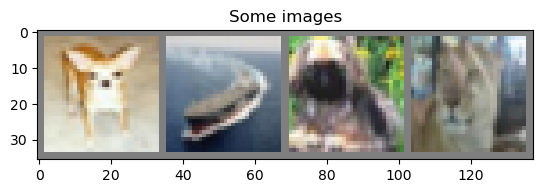

dog   ship  dog   cat  


In [10]:
# functions to show an image


def imshow(img, title):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images), 'Some images')
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

##### 2. Define a Convolutional Neural Network

In [11]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2, return_indices=True)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        self.cnn_output = [None, None, None]
        self.cnn_output_indices = [None, None]

        self.deconv2 = nn.ConvTranspose2d(16, 6, 5)
        self.deconv1 = nn.ConvTranspose2d(6, 3, 5)
        self.unpool = nn.MaxUnpool2d(2, 2)
        
    def forward(self, x):
        self.cnn_output[0] = x
        x, indices = self.pool(F.relu(self.conv1(x)))
        self.cnn_output_indices[0] = indices
        self.cnn_output[1] = x
        x, indices = self.pool(F.relu(self.conv2(x)))
        self.cnn_output_indices[1] = indices
        self.cnn_output[2] = x
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

##### 3. Define a Loss function and optimizer


In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

##### 4. Train the network

In [13]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.214
[1,  4000] loss: 1.824
[1,  6000] loss: 1.662
[1,  8000] loss: 1.565
[1, 10000] loss: 1.509
[1, 12000] loss: 1.475
[2,  2000] loss: 1.413
[2,  4000] loss: 1.379
[2,  6000] loss: 1.341
[2,  8000] loss: 1.320
[2, 10000] loss: 1.300
[2, 12000] loss: 1.270
Finished Training


In [14]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

##### 5. Test the network on the test data

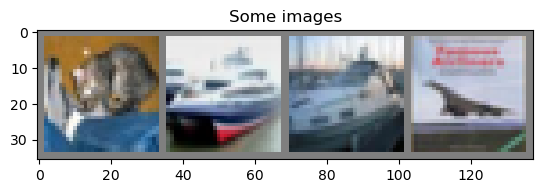

GroundTruth:  cat   ship  ship  plane


In [15]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images), 'Some images')
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [16]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [17]:
outputs = net(images)

In [18]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   car   ship  plane


In [19]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 56 %


In [20]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 58.6 %
Accuracy for class: car   is 76.7 %
Accuracy for class: bird  is 46.0 %
Accuracy for class: cat   is 35.1 %
Accuracy for class: deer  is 49.1 %
Accuracy for class: dog   is 37.5 %
Accuracy for class: frog  is 71.8 %
Accuracy for class: horse is 63.4 %
Accuracy for class: ship  is 64.3 %
Accuracy for class: truck is 61.0 %


### Task 2

In [21]:
def cnn_hook(module, input, output):
    net.cnn_output = output

net.pool.register_forward_hook(cnn_hook)

print((net.cnn_output[0]).shape)
print((net.cnn_output[1]).shape)
print((net.cnn_output[2]).shape)

torch.Size([4, 3, 32, 32])
torch.Size([4, 6, 14, 14])
torch.Size([4, 16, 5, 5])


In [22]:
print((net.cnn_output_indices[0]).shape)
print((net.cnn_output[1]).shape)

print((net.cnn_output_indices[1]).shape)
print((net.cnn_output[2]).shape)

torch.Size([4, 6, 14, 14])
torch.Size([4, 6, 14, 14])
torch.Size([4, 16, 5, 5])
torch.Size([4, 16, 5, 5])


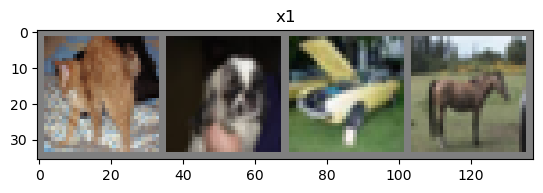

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


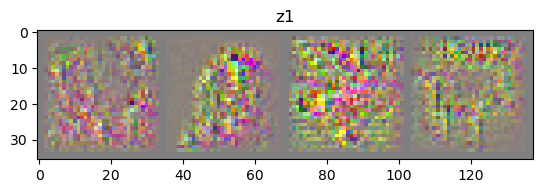

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


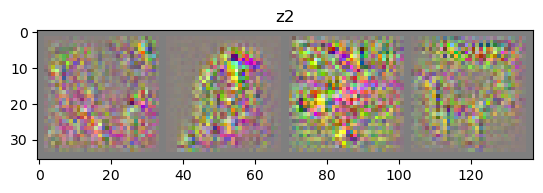

In [28]:
x1 = net.cnn_output[0]

z1 = net.cnn_output[1]
z1 = net.unpool(net.cnn_output[1], net.cnn_output_indices[0])
z1 = F.relu(z1)
z1 = net.deconv1(z1)

z2 = net.unpool(net.cnn_output[2], net.cnn_output_indices[1])
z2 = F.relu(z2)
z2 = net.deconv2(z2)
z2 = net.unpool(net.cnn_output[1], net.cnn_output_indices[0])
z2 = F.relu(z2)
z2 = net.deconv1(z2)

imshow(torchvision.utils.make_grid(x1), "x1")
imshow(torchvision.utils.make_grid(z1), "z1")
imshow(torchvision.utils.make_grid(z2), "z2")
